In [1]:
from data_treat.get_ready_data import get_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, accuracy_score # метрики качества
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from data_treat.data_normalizer import CustomNormalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

In [2]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order", "fraud"]

In [3]:
def summ_func(x):
    print(x)
    return sum(x)

In [4]:
data = get_data()
pd.value_counts(data['fraud'])

0.0    87403
1.0    87403
Name: fraud, dtype: int64

In [5]:
data.values

array([[2.08433859e+01, 1.44180943e+00, 5.04188009e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.49000429e+02, 7.84454106e+00, 6.00786952e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.07753109e+02, 6.89880722e-01, 2.36185743e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [5.19556691e+01, 1.61103719e-01, 7.94039586e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.58852557e+02, 4.67397384e+00, 2.12819106e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.46634361e+00, 5.55479592e-01, 4.50759955e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [6]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
27283,20.843386,1.441809,5.041880,1.0,1.0,1.0,0.0,0.0
48312,349.000429,7.844541,0.600787,1.0,1.0,0.0,1.0,0.0
489745,107.753109,0.689881,2.361857,1.0,0.0,0.0,1.0,1.0
76053,0.671037,20.939283,4.078705,0.0,1.0,0.0,1.0,1.0
357734,5.906675,0.178226,10.872932,1.0,1.0,0.0,1.0,1.0


In [7]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)


In [8]:
labels.head()


27283     0.0
48312     0.0
489745    1.0
76053     1.0
357734    1.0
Name: fraud, dtype: float64

In [9]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
27283,20.843386,1.441809,5.041880,1.0,1.0,1.0,0.0
48312,349.000429,7.844541,0.600787,1.0,1.0,0.0,1.0
489745,107.753109,0.689881,2.361857,1.0,0.0,0.0,1.0
76053,0.671037,20.939283,4.078705,0.0,1.0,0.0,1.0
357734,5.906675,0.178226,10.872932,1.0,1.0,0.0,1.0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [13]:
def model_func(x_train, x_test):
    def gridSearch(X,y):

        param_dict = {
        'n_neighbors': np.arange(1,3,1),
        }
        model = KNeighborsClassifier()
        gv = GridSearchCV(model,param_grid=param_dict)
        gv.fit(X,y)
        return gv.best_score_,gv.best_params_



    params = gridSearch(x_train, y_train)
    print(params)

    model = KNeighborsClassifier(n_neighbors=params[1]['n_neighbors'])
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    print("Accuracy : ",accuracy_score(y_test,predictions)*100)
    print(confusion_matrix(y_test, predictions))

    test_probabilities = model.predict_proba(x_test)
    test_probabilities = test_probabilities[:, 1]
    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

    plt.figure(figsize=(7, 7))

    # рисуем кривую
    plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

    # кривая, соответствующая случайному угадыванию
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
    plt.legend()
    plt.show()

    roc_auc_value = roc_auc_score(y_test, test_probabilities)

    print("ROC-AUC на тестовой выборке:", roc_auc_value)


    label0 = x_test[predictions==0][::900]
    label1 = x_test[predictions==1][::900]
    embedding_0 = MDS(n_components=2)
    embedding_1 = MDS(n_components=2)
    mds_0 = pd.DataFrame(embedding_0.fit_transform(label0),
                columns = ['component1','component2'])

    mds_1 = pd.DataFrame(embedding_1.fit_transform(label1),
                columns = ['component1','component2'])

    sns.scatterplot(data=mds_0,x = "component1",y="component2",color="red")
    sns.scatterplot(data=mds_1,x = "component1",y="component2",color="blue")

Для сырых данных

Для нормализованных данных

(0.9690829918032786, {'n_neighbors': 1})
Accuracy :  97.28703671601428
[[27373  1213]
 [  352 28748]]


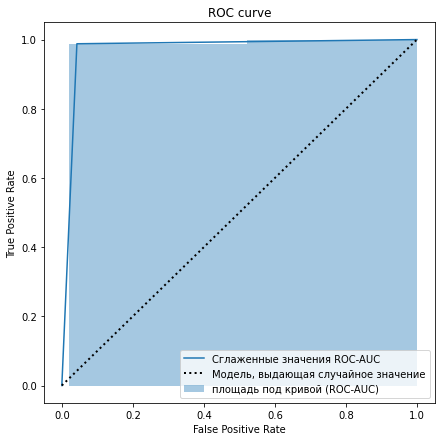

ROC-AUC на тестовой выборке: 0.972735210540906


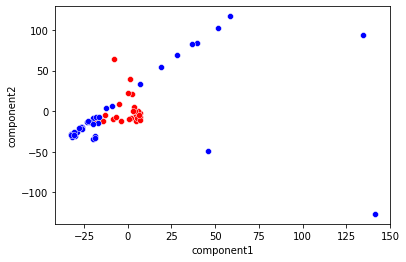

In [14]:
model_func(x_train, x_test)

Для Нормализованных данных

(0.9966700819672131, {'n_neighbors': 1})
Accuracy :  90.15012308012342
[[23422  5477]
 [  205 28582]]


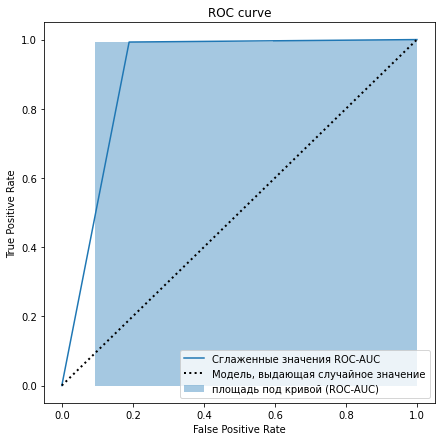

ROC-AUC на тестовой выборке: 0.90167830059445


In [36]:
model_func(CustomNormalizer.normalize(x_train),CustomNormalizer.normalize(x_test))

Для стандартизированных данных


(0.9965761612021857, {'n_neighbors': 1})
Accuracy :  99.29098914814686
[[28748   151]
 [  258 28529]]


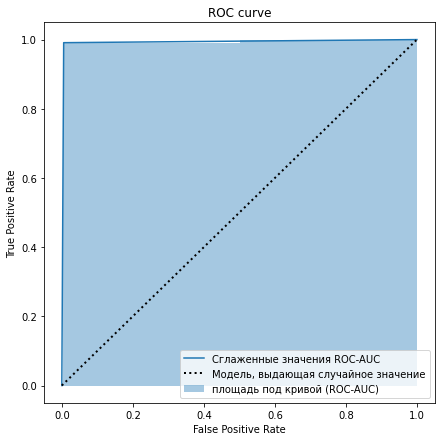

ROC-AUC на тестовой выборке: 0.9929062634272574


In [37]:
model_func(CustomNormalizer.standardize(x_train),CustomNormalizer.standardize(x_test))